In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy

In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)
LG = pklload("./database/00_LocalGroup_fix.pickle")
print(LG.keys())
print(LG[2].keys())

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
dict_keys([1, 2, 3, 4, 7, 8, 9, 10, 14, 17, 23, 24, 25, 26, 29, 35, 36, 37, 40, 46, 47, 52, 63, 64, 75, 84, 92, 107, 108, 121, 129, 207, 11])
dict_keys(['BGG', 'neighbor', 'sats', 'subs', 'real'])


In [3]:
subids = None
for key in LG.keys():
    tmp = LG[key]['real']['hid']
    tmp = tmp[tmp>0]
    subids = tmp if(subids is None) else np.union1d(subids, tmp)
print( subids.shape )

for subid in tqdm( subids ):
    if(os.path.exists(f"./database/submember/z017/DM_{subid:07d}.pickle")): continue
    mem = uhmi.HaloMaker.read_member_part(snap, subid, galaxy=False, target_fields=['x','y','z','id'])
    pklsave(mem.table, f"./database/submember/z017/DM_{subid:07d}.pickle")

(2874,)


100%|██████████| 2874/2874 [00:00<00:00, 6027.09it/s]


In [4]:
zreds = np.array([0.17, 0.3, 0.5,0.7, 1,1.2, 1.5, 2,2.5, 3])
aexps = 1/(1+zreds)
iouts = np.zeros(len(zreds), dtype=np.int32)
for i in range(len(zreds)):
    arg = np.argmin(np.abs(snaps.iout_avail['aexp']-aexps[i]))
    iouts[i] = snaps.iout_avail['iout'][arg]
dirnames = [f"z{round(snaps.get_snap(iout).z*100):03d}" for iout in iouts]
print(iouts)
print(dirnames)

[Output 00871] Age (Gyr) : 10.335 / 13.741, z = 0.29925 (a = 0.7697)
[Output 00717] Age (Gyr) : 8.686 / 13.741, z = 0.50068 (a = 0.6664)
[Output 00600] Age (Gyr) : 7.413 / 13.741, z = 0.69953 (a = 0.5884)
[Output 00446] Age (Gyr) : 5.959 / 13.741, z = 1.00134 (a = 0.4997)
[Output 00392] Age (Gyr) : 5.224 / 13.741, z = 1.20160 (a = 0.4542)
[Output 00335] Age (Gyr) : 4.370 / 13.741, z = 1.49898 (a = 0.4002)
[Output 00252] Age (Gyr) : 3.366 / 13.741, z = 1.99586 (a = 0.3338)
[Output 00196] Age (Gyr) : 2.677 / 13.741, z = 2.50429 (a = 0.2854)
[Output 00158] Age (Gyr) : 2.197 / 13.741, z = 3.00643 (a = 0.2496)
[1026  871  717  600  446  392  335  252  196  158]
['z017', 'z030', 'z050', 'z070', 'z100', 'z120', 'z150', 'z200', 'z250', 'z301']


See `02_sparse_evolution.py`  
Output:  
- `./database/submember/{dirname}/DM_{subid:07d}.pickle`

In [5]:
key = 11
BGG = LG[key]['BGG']
sats = LG[key]['sats']
subs = LG[key]['subs']
subs.shape, sats.shape

((36,), (8,))

In [6]:
LG[key]['real']

array([( 5493,   -1, 'dink'), (24608,   -1, 'dink'),
       (24611,   -1, 'dink'), (24613,   -1, 'dink'),
       (24615,   -1, 'dink'), (24616,   -1, 'dink'),
       (24628,   -1, 'dink'), (24630,   -1, 'dink'),
       (24632,   -1, 'dink'), (24633,   -1, 'dink'),
       (24635,   -1, 'dink'), (24636,   -1, 'dink'),
       (24639,   -1, 'dink'), (24642,   -1, 'dink'),
       (24644,   -1, 'dink'), (24649,  326, 'pair'),
       (24650,   -1, 'dink'), (24651,   -1, 'dink'),
       (24652,  513, 'pair'), (24653,   -1, 'dink'),
       (24657,   -1, 'dink'), (24658,   -1, 'dink'),
       (24659,   -1, 'dink'), (24661,   -1, 'dink'),
       (24662, 1039, 'pair'), (24664,   -1, 'dink'),
       (24665,   -1, 'dink'), (24666,  660, 'pair'),
       (24667,   -1, 'dink'), (24668,  210, 'pair'),
       (24669,   -1, 'dink'), (24670,   -1, 'dink'),
       (24671,  870, 'pair'), (24672,   -1, 'dink'),
       (24673,   21, 'pair'), (24674,   -1, 'dink'),
       (    0, 1866, 'orphan')],
      dtype=[

In [7]:
iouts

array([1026,  871,  717,  600,  446,  392,  335,  252,  196,  158],
      dtype=int32)

In [8]:
def outsider(parts, threshold=0.2, frac=0.01):
    nfrac = int(len(parts)*frac)
    if(len(parts)<10000):
        distarr = np.zeros((len(parts), len(parts)))
        for i in range(len(parts)):
            distarr[i] = distance(parts[i], parts)
        mediandist = np.median(distarr.flatten())
        check = distarr < threshold*mediandist
        check = np.sum(check, axis=1)
    else:
        # Calc median distance first
        distarr = np.zeros(len(parts))
        for i in tqdm( range(len(parts)),desc="median" ):
            distarr[i] = np.median(distance(parts[i], parts))
        mediandist = np.median(distarr)

        # Check
        check = np.zeros(len(parts))
        for i in tqdm( range(len(parts)), desc='check' ):
            check[i] = np.sum(distance(parts[i], parts) < threshold*mediandist)
    return check<=nfrac

In [9]:
np.argmax(subs['nparts'])

29

In [10]:
np.max(hals['nparts'])

6741842

24666
4164
158 (0.5, 0.0, 0.0, 1.0)
196 (0.9456327985739753, 0.029774872912127992, 0.0, 1.0)
252 (1.0, 0.40740740740740755, 0.0, 1.0)
335 (1.0, 0.7705156136528688, 0.0, 1.0)
392 (0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
446 (0.4901960784313725, 1.0, 0.4775458570524984, 1.0)
600 (0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
717 (0.0, 0.692156862745098, 1.0, 1.0)
871 (0.0, 0.3, 1.0, 1.0)


1026 (0.0, 0.0, 0.945632798573975, 1.0)


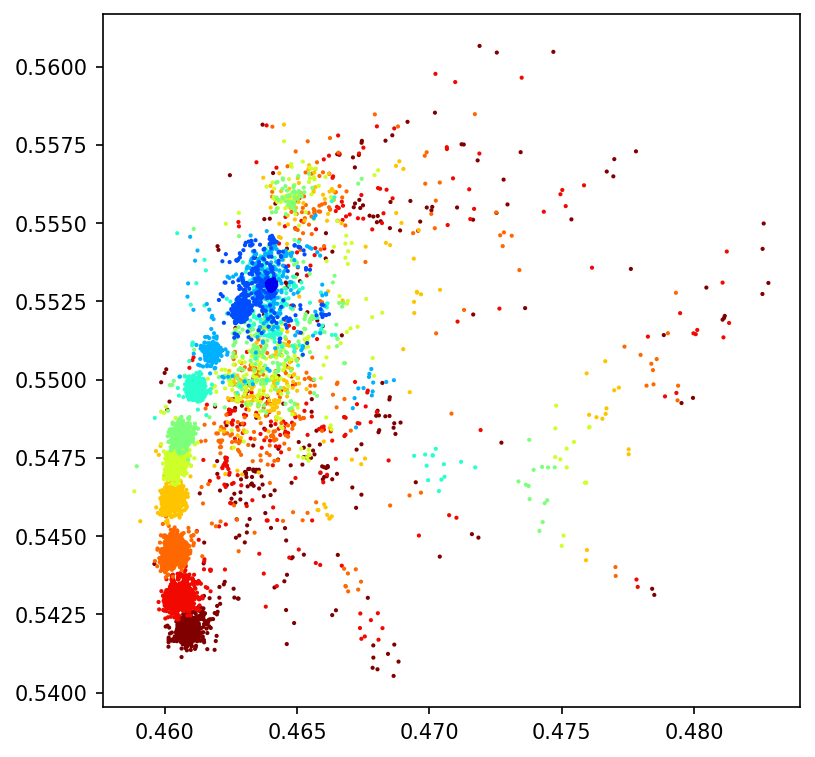

In [11]:
target = subs[27]
print( target['id'] )
print(target['nparts'])


fig, ax = plt.subplots(figsize=(6,6), dpi=150)
import matplotlib as mpl
cmap = mpl.colormaps['jet']


fiducial_dtype = np.dtype( [('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('id', '<i4')] )
parts = None
npart = 0
i=1.0
for iout,dirname in zip(iouts[::-1],dirnames[::-1]):
    path = f"./database/submember/{dirname}/DM_{target['id']:07d}.pickle"
    tmp = pklload(path)
    if(npart==0): npart = len(tmp)
    if(not np.array_equal(tmp.dtype.descr, fiducial_dtype.descr)):
        tmp2 = np.zeros(npart, dtype=fiducial_dtype)
        for name in fiducial_dtype.names:
            tmp2[name] = tmp[name]
        pklsave(tmp2, path, overwrite=True)
        tmp = tmp2

    dtype = np.dtype( fiducial_dtype.descr + [('iout', '<i4')] )
    part = np.zeros(npart, dtype=dtype)
    for name in tmp.dtype.names:
        part[name] = tmp[name]
    part['iout'] = iout
    parts = part if(parts is None) else np.hstack((parts, part))

    rgba = cmap(i); i-=0.1
    print(iout, rgba)
    ax.scatter(part['x'], part['y'], ec='none',fc=rgba, s=4)

# argsort = np.lexsort((parts['iout'], parts['id']))
# parts = parts[argsort]


# tmp = parts[parts['iout']==iouts[9]]
# dists = distance(tmp, target)
# tmp = tmp[dists < np.median(dists)]
# ind = outsider(tmp); print(len(tmp), np.sum(ind))
# while(np.sum(ind)>0):
#     tmp = tmp[~ind]
#     ind = outsider(tmp); print(len(tmp), np.sum(ind))
# ax.scatter(tmp['x'], tmp['y'], c='r', s=1)

# tmp = parts[parts['iout']==iouts[4]]
# dists = distance(tmp, target)
# tmp = tmp[dists < np.median(dists)]
# ind = outsider(tmp); print(len(tmp), np.sum(ind))
# while(np.sum(ind)>0):
#     tmp = tmp[~ind]
#     ind = outsider(tmp); print(len(tmp), np.sum(ind))
# ax.scatter(tmp['x'], tmp['y'], c='g', s=1)

# for i in range(npart):
#     iparts = parts[i*10:(i+1)*10]
#     if(iparts[0]['id'] in tmp['id']):
#         ax.plot(iparts['x'], iparts['y'], c='k', lw=0.2, zorder=-1)
#     else:
#         ax.plot(iparts['x'], iparts['y'], c='grey', lw=0.2, zorder=-1, alpha=0.5)



# tmp = parts[parts['iout']==iouts[4]]
# ax.scatter(tmp['x'], tmp['y'], c='g', s=1)
# tmp = parts[parts['iout']==iouts[0]]
# ax.scatter(tmp['x'], tmp['y'], c='b', s=1)




# Find center

In [14]:
def discrete(parts):
    iparts = parts

    x1 = iparts['x'].min(); x2 = iparts['x'].max(); xc = (x1+x2)/2; dx = x2-x1
    ind = iparts['x']<xc
    if(np.sum(ind) > len(ind)/2): iparts = iparts[iparts['x'] < (xc+dx/4)]
    else: iparts = iparts[iparts['x'] > (xc-dx/4)]

    y1 = iparts['y'].min(); y2 = iparts['y'].max(); yc = (y1+y2)/2; dy = y2-y1
    ind = iparts['y']<yc
    if(np.sum(ind) > len(ind)/2): iparts = iparts[iparts['y'] < (yc+dy/4)]
    else: iparts = iparts[iparts['y'] > (yc-dy/4)]

    z1 = iparts['z'].min(); z2 = iparts['z'].max(); zc = (z1+z2)/2; dz = z2-z1
    ind = iparts['z']<zc
    if(np.sum(ind) > len(ind)/2): iparts = iparts[iparts['z'] < (zc+dz/4)]
    else: iparts = iparts[iparts['z'] > (zc-dz/4)]

    return iparts

def iterdis(parts, frac=0.3):
    iparts = parts
    dn = 0
    while(dn / len(iparts) < frac):
        nold = len(iparts)
        iparts = discrete(iparts)
        nnew = len(iparts)
        dn = nold-nnew

In [21]:
np.unique(parts['iout'])

array([ 158,  196,  252,  335,  392,  446,  600,  717,  871, 1026],
      dtype=int32)

4109
4049
3994
3936
3906
3870
3818
3650
3385
2696
2164
1496
1082


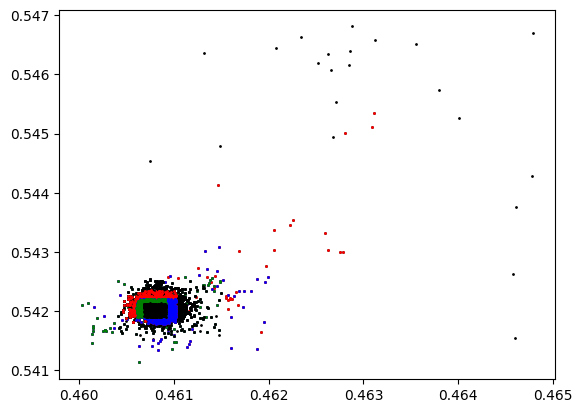

In [26]:
tmp = parts[parts['iout'] == 158]
# plt.scatter(tmp['x'], tmp['y'], c='k', s=1)
tmp = discrete(tmp); print(len(tmp))
# plt.scatter(tmp['x'], tmp['y'], c='r', s=1)
tmp = discrete(tmp); print(len(tmp))
# plt.scatter(tmp['x'], tmp['y'], c='b', s=1)
tmp = discrete(tmp); print(len(tmp))
# plt.scatter(tmp['x'], tmp['y'], c='g', s=1)
tmp = discrete(tmp); print(len(tmp))
plt.scatter(tmp['x'], tmp['y'], c='k', s=1)
tmp = discrete(tmp); print(len(tmp))
plt.scatter(tmp['x'], tmp['y'], c='r', s=1)
tmp = discrete(tmp); print(len(tmp))
plt.scatter(tmp['x'], tmp['y'], c='b', s=1)
tmp = discrete(tmp); print(len(tmp))
plt.scatter(tmp['x'], tmp['y'], c='g', s=1)
tmp = discrete(tmp); print(len(tmp))
plt.scatter(tmp['x'], tmp['y'], c='k', s=1)
tmp = discrete(tmp); print(len(tmp))
plt.scatter(tmp['x'], tmp['y'], c='k', s=1)
tmp = discrete(tmp); print(len(tmp))
plt.scatter(tmp['x'], tmp['y'], c='r', s=1)
tmp = discrete(tmp); print(len(tmp))
plt.scatter(tmp['x'], tmp['y'], c='b', s=1)
tmp = discrete(tmp); print(len(tmp))
plt.scatter(tmp['x'], tmp['y'], c='g', s=1)
tmp = discrete(tmp); print(len(tmp))
plt.scatter(tmp['x'], tmp['y'], c='k', s=1)
